In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


<Axes: xlabel='fare_class', ylabel='count'>

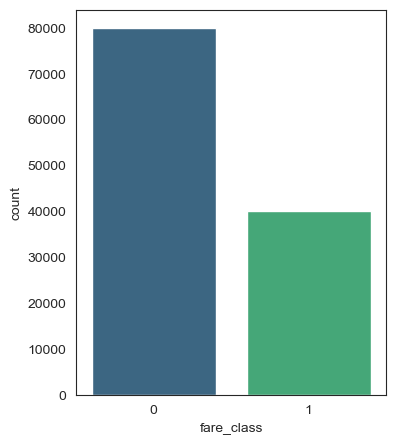

In [4]:
#target - fare class
sns.set_style('white')
plt.figure(figsize=(4,5))
sns.countplot(x = 'fare_class' ,data=df,palette='viridis')

In [5]:
#distance
def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)

    return d

In [6]:
df['distance'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [7]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [8]:
#extracting datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
df['datetime'] = df['pickup_datetime']-pd.Timedelta(hours=4)

In [10]:
df.drop('pickup_datetime',axis=1,inplace=True)

In [11]:
df['Hrs'] = df['datetime'].apply(lambda date : date.hour)

In [12]:
df['min'] = df['datetime'].apply(lambda date : date.minute)

In [13]:
df['am_pm'] = df['Hrs'].apply(lambda hr : "AM" if hr < 12 else "PM")

In [14]:
df['Date'] = df['datetime'].apply(lambda date : date.day)

In [15]:
df['Week_day'] = df['datetime'].apply(lambda date : date.day_of_week)

In [16]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,datetime,Hrs,min,am_pm,Date,Week_day
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,17,AM,19,0
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,43,AM,17,5
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,23,AM,17,5
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,25,PM,11,6
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,19,PM,16,4


In [17]:
df.drop(['fare_amount','datetime'],axis=1,inplace=True)

In [18]:
cat_cols = ['Hrs', 'min', 'am_pm', 'Date', 'Week_day']
num_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance']
y_col = ['fare_class']


In [19]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [20]:
cats = np.stack([df[col].cat.codes for col in cat_cols],axis=1)

In [21]:
df['Hrs'].cat.codes

0          4
1         11
2          7
3         17
4         22
          ..
119995    10
119996     6
119997    14
119998     4
119999    12
Length: 120000, dtype: int8

In [22]:
conts = np.stack([df[col].values for col in num_cols],axis=1)

In [23]:
cats = torch.tensor(cats,dtype=torch.int32)

In [24]:
conts = torch.tensor(conts,dtype=torch.float32)

In [25]:
y = torch.tensor(df[y_col].values)

In [26]:
y

tensor([[0],
        [0],
        [1],
        ...,
        [1],
        [0],
        [0]])

In [27]:
y

tensor([[0],
        [0],
        [1],
        ...,
        [1],
        [0],
        [0]])

In [28]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (60, 30), (2, 1), (14, 7), (7, 4)]

### model

In [29]:
class Model(nn.Module):
    
    def __init__(self,emb_szs,n_cont,out_sz,layers,p=0.4):
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.em_drop = nn.Dropout(p)
        n_emb = sum([nf for ni,nf in emb_szs ])
        
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_in = n_cont + n_emb
        
        layerlist = []
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self,x_cat,x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings,1)
        x = self.em_drop(x)
            
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x

In [30]:
device = torch.device("mps")
model = Model(emb_szs,conts.shape[1],2,[128,64,32,16,8,4],p=0.4)
model.to(device)

Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(60, 30)
    (2): Embedding(2, 1)
    (3): Embedding(14, 7)
    (4): Embedding(7, 4)
  )
  (em_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_fea

In [31]:
batch_size = len(df)
test_size = int(batch_size*0.2)

In [32]:
cat_train = cats[:batch_size-test_size].to(device)
cat_test = cats[batch_size-test_size:].to(device)
cont_train = conts[:batch_size-test_size].to(device)
cont_test = conts[batch_size-test_size:].to(device)
y_train = y[:batch_size-test_size].to(device)
y_test = y[batch_size-test_size:].to(device)

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [35]:
num_epochs = 1500
losses = []
for epoch in range(num_epochs):
    y_pred = model.forward(cat_train,cont_train)
    loss = criterion(y_pred,y_train.squeeze())
    losses.append(loss.item())
    if (epoch+1)%10 == 0:
        print(f"epoch : {epoch+1}/{num_epochs} loss : {loss.item()}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch : 10/1500 loss : 0.7278299331665039
epoch : 20/1500 loss : 0.5701934695243835
epoch : 30/1500 loss : 0.4245424270629883
epoch : 40/1500 loss : 0.3753288984298706
epoch : 50/1500 loss : 0.35354578495025635
epoch : 60/1500 loss : 0.3432753086090088
epoch : 70/1500 loss : 0.33722224831581116
epoch : 80/1500 loss : 0.32985302805900574
epoch : 90/1500 loss : 0.32600289583206177
epoch : 100/1500 loss : 0.32229292392730713
epoch : 110/1500 loss : 0.32513245940208435
epoch : 120/1500 loss : 0.32221269607543945
epoch : 130/1500 loss : 0.31559810042381287
epoch : 140/1500 loss : 0.3142234981060028
epoch : 150/1500 loss : 0.30977413058280945
epoch : 160/1500 loss : 0.30944570899009705
epoch : 170/1500 loss : 0.3060839772224426
epoch : 180/1500 loss : 0.30526912212371826
epoch : 190/1500 loss : 0.30177533626556396
epoch : 200/1500 loss : 0.29665428400039673
epoch : 210/1500 loss : 0.2923181653022766
epoch : 220/1500 loss : 0.29014283418655396
epoch : 230/1500 loss : 0.28529369831085205
epoch

In [36]:
with torch.no_grad():
    y_eval = model.forward(cat_test,cont_test)
    loss_test = criterion(y_eval,y_test.squeeze())

In [37]:
print(loss_test)

tensor(0.2714, device='mps:0')


In [38]:
torch.save(model,"NYCTaxiFare_class_1500.pt")